# Homework 2 | Zaitsev

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Data

The data we will be analysing is **CO2 Emission Per Capita in Luxembourg**, which can be downloaded from `ourworldindata.org`: 

https://ourworldindata.org/co2/country/luxembourg

In [2]:
data_dir = "data/"
data_path = data_dir + "HWII_data_Zaitsev.csv"

feature = "co2"
feature_map = {
    "co2": "Annual CO₂ Emissions (per capita)",
}

data = pd.read_csv(data_path)

In [3]:
data

,year,co2
0,1950,25.014633
1,1951,30.210049
2,1952,31.331244
3,1953,28.677290
4,1954,28.934362
...,...,...
68,2018,15.748627
69,2019,15.757939
70,2020,12.797711
71,2021,13.185230


## Question 1: STATIONARITY & TRANSFROMATIONS

- Clean the data of outliers or breaks.
- Decide and describe whether the series is stationary or not. Support your argument with ACF and PACF functions, as well as statistical tests. Explain which transformation you will use to make the series stationary and ready for modelling.

### Data Analysis

First, we will analyze our data by plotting it and seeing if there are any anomalies that need to be solved.

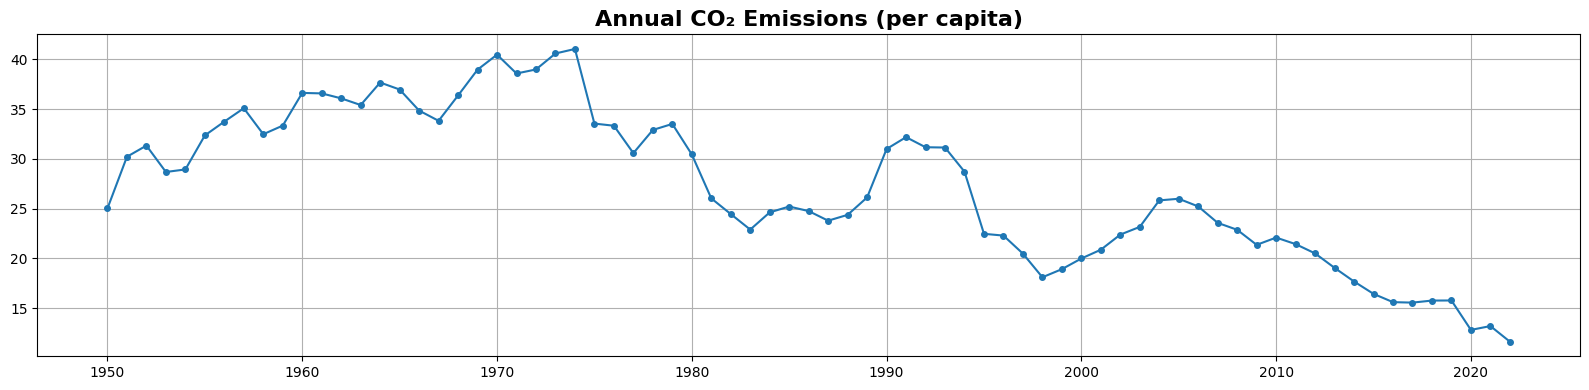

In [4]:
figure, ax = plt.subplots(figsize=(16, 4)) 
ax.plot(data["year"], data[feature], marker="o", markersize=4)
ax.set_title(feature_map[feature], fontsize=16, fontweight="bold")
plt.tight_layout()
plt.grid()
plt.show()

The `data` looks `clean`, `smooth` and `no breaks` are present in the data. However, the data does `not` look `stationary`, so we need to either calculate growth rates or first differences. Let us calculate first differences and then check for the stationarity for both raw and first differenced data.

### First Differencing

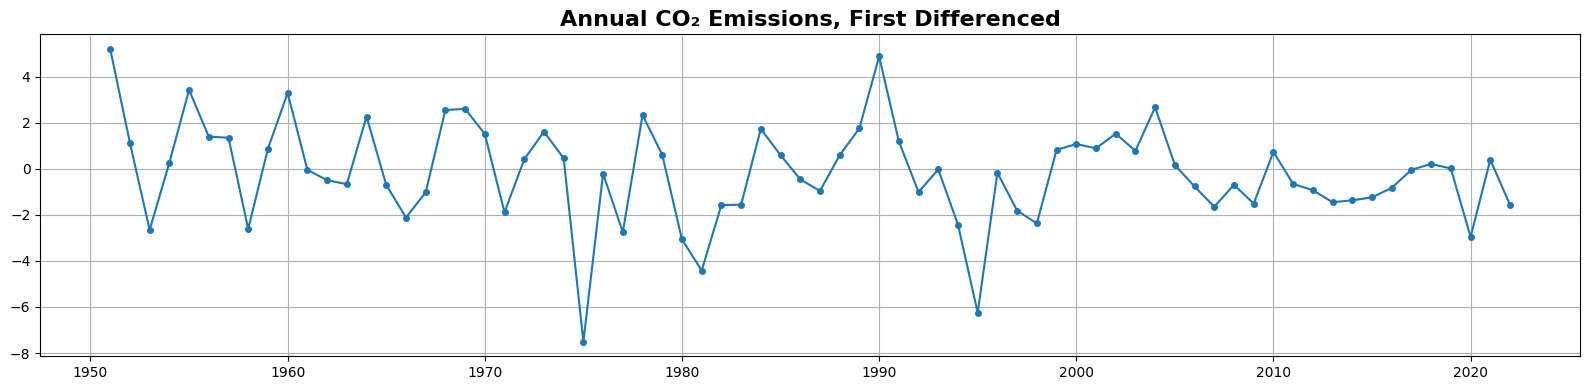

In [5]:
stationary_feature = "co2_diff"
feature_map[stationary_feature] = "Annual CO₂ Emissions, First Differenced"
data[stationary_feature] = data[feature].diff(periods=1)
data.dropna(inplace=True)

figure, ax = plt.subplots(figsize=(16, 4)) 
ax.plot(data["year"], data[stationary_feature], marker="o", markersize=4)
ax.set_title(feature_map[stationary_feature], fontsize=16, fontweight="bold")
plt.tight_layout()
plt.grid()
plt.show()

This looks a little better, but `some` of the `values` are too `extreme`, e.g. a value around year $1975$. Let us perform outlier analysis and `smooth` the `data`.

### Outliers

From the first differenced $\text{CO}_2$ emissions plot we can notice some exteme values, i.e. outliers. To deal with them we will use `smooth_outliers()` function that detects outliers based on the interquartile range (IQR) method, flagging values outside of a specified range $\left(k \times \text{IQR}\right)$. Detected outliers are replaced with a two-sided rolling mean calculated over a window of size $n$.

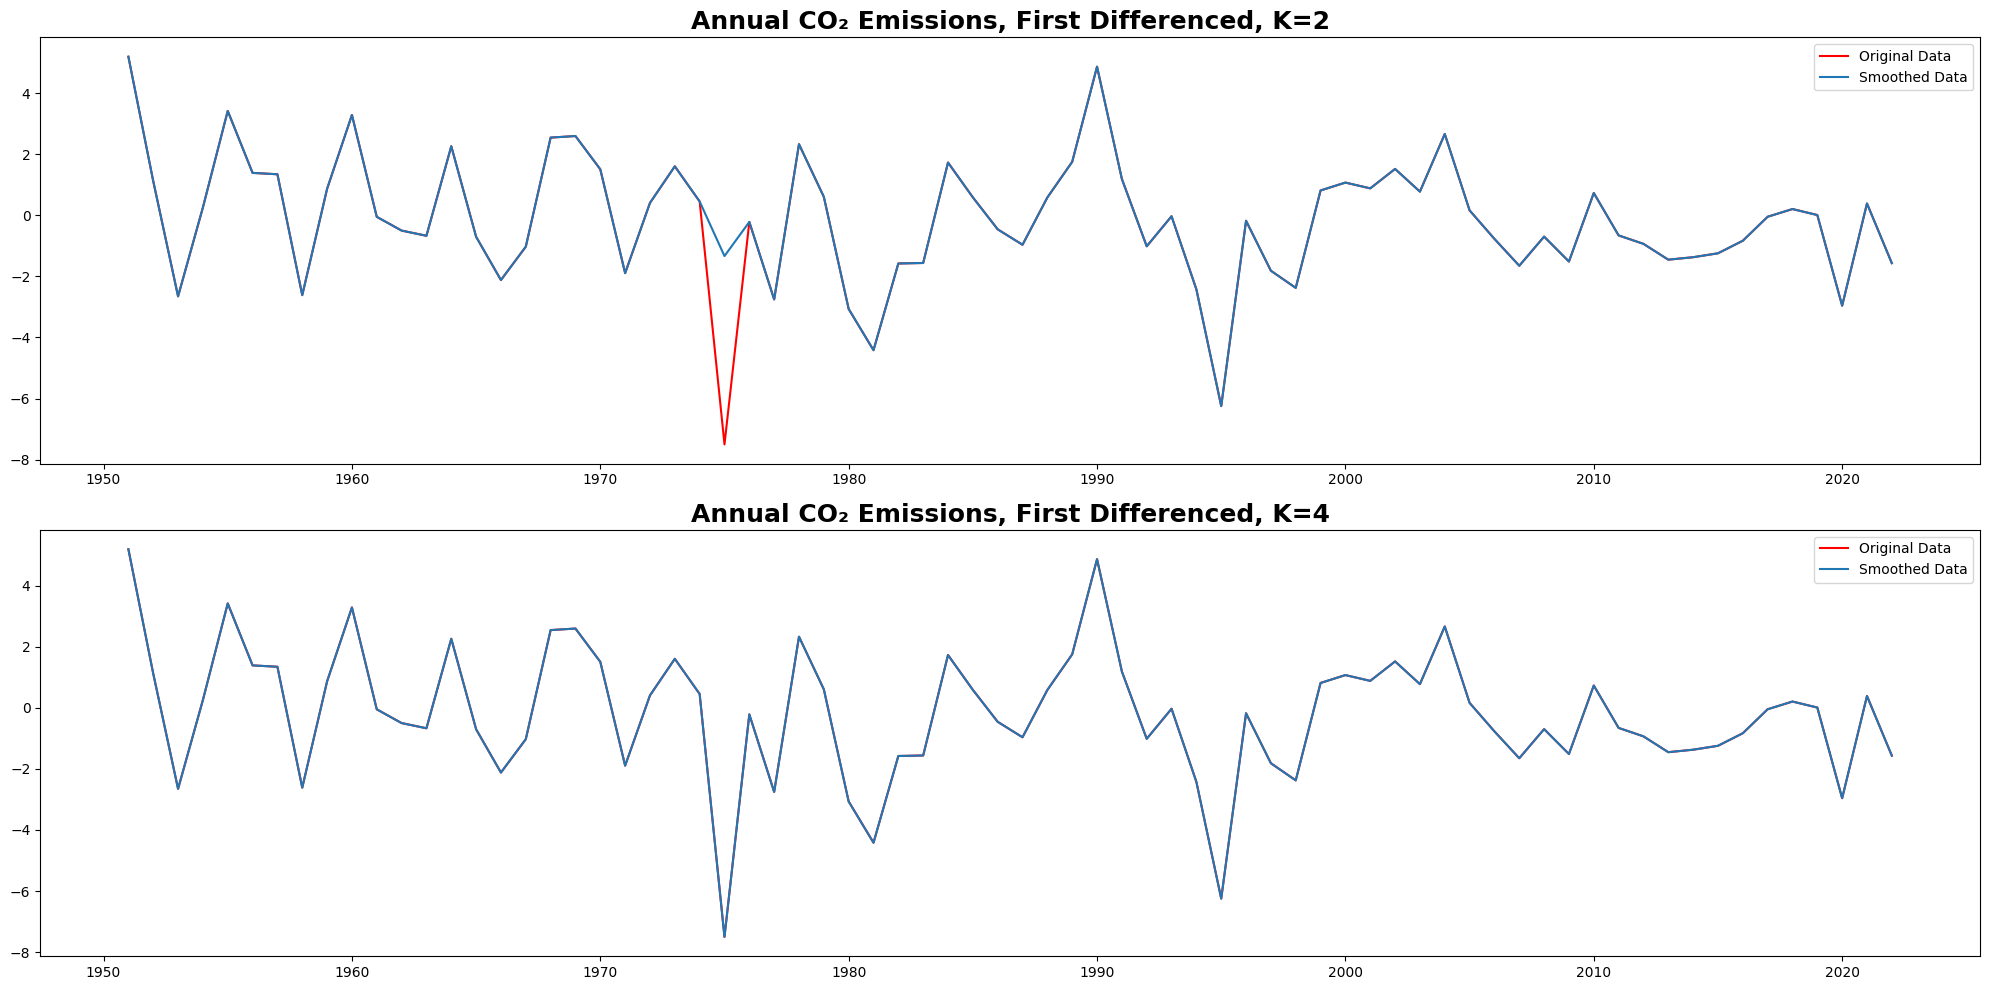

In [6]:
def smooth_outliers(df, column, k, n):
    out = df.copy()
    # first, second quartiles and inter-quartile range
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    # find indecies outside of normal range
    ind = ~out[column].between(q1-k*iqr, q3+k*iqr, inclusive="both")
    # compute two-sided rolling mean for whole data
    col_sm = df[column].rolling(window=n, center=True, min_periods=None).mean()
    # replace outliers with two-sided rolling mean    
    out.loc[ind, column] = col_sm[ind]       
    return out

data_smooth_2 = smooth_outliers(data, stationary_feature, 2, 6)
data_smooth_4 = smooth_outliers(data, stationary_feature, 4, 6)

# plot
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
# with k=2
axs[0].plot(data["year"], data[stationary_feature],"-r", label="Original Data")
axs[0].plot(data["year"], data_smooth_2[stationary_feature], label="Smoothed Data")
axs[0].legend()
axs[0].set_title(f"{feature_map[stationary_feature]}, K=2", fontsize=18, fontweight="bold")
# with k=4
axs[1].plot(data["year"], data[stationary_feature],"-r", label="Original Data")
axs[1].plot(data["year"], data_smooth_4[stationary_feature], label="Smoothed Data")
axs[1].legend()
axs[1].set_title(f"{feature_map[stationary_feature]}, K=4", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

With $K=4$ we do not detect any outliers. However, with $K=2$ we detect exactly the value that we mentioned before, the one around year $1975$. This value is somewhat too extreme, so for further analysis let us continue with the smoothed out data with $K=2$, i.e. `data_smooth_2`.

### Stationarity

In this section we will check the stationarity of the data. We will plot `ACF`, `PACF` and use `ADF` (Augmented Dickey-Fuller) and `KPSS` (Kwiatkowski-Phillips-Schmidt-Shin) tests for stationarity. For the reference:

- `ADF`: $H_0$: The time series has a unit root (is `NON-STATIONARY`).
- `KPSS`: $H_0$: The time series is `STATIONARY`.

#### ACF & PACF

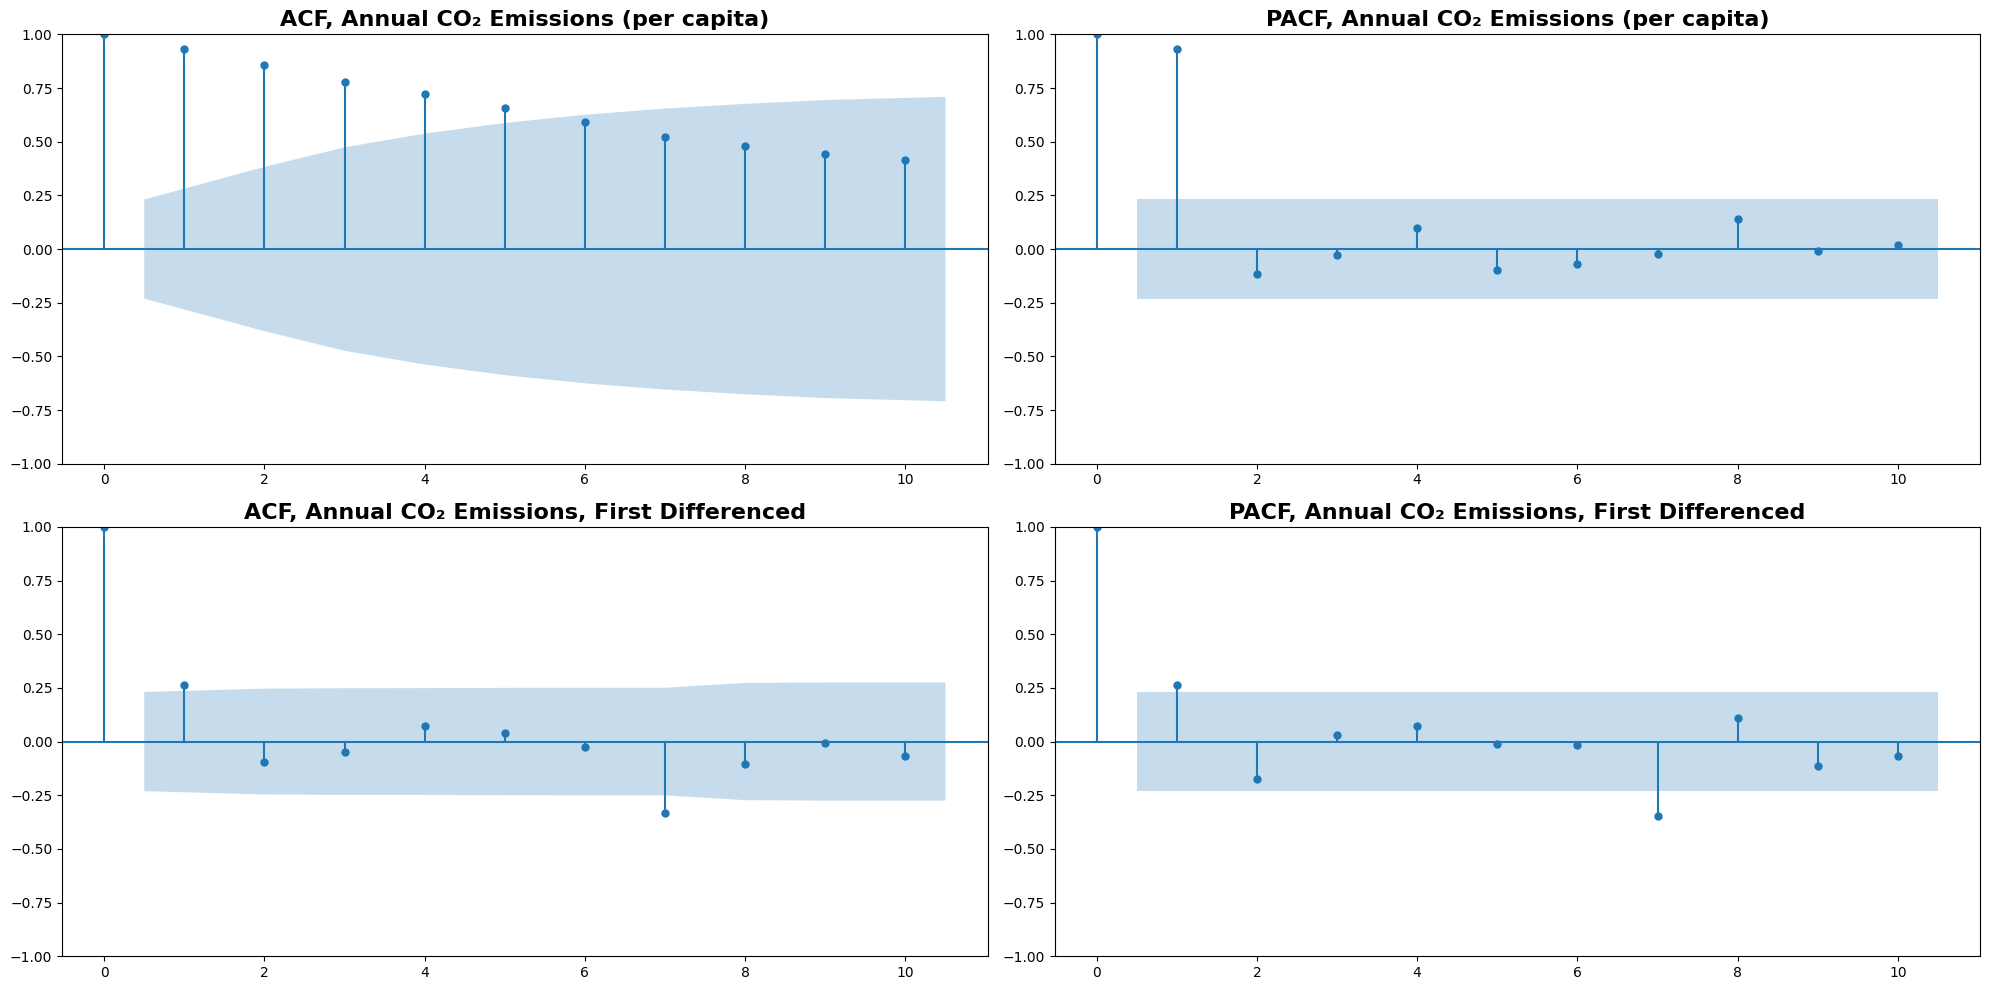

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
# plot ACF, PACF for raw data
# ACF
sm.graphics.tsa.plot_acf(data_smooth_2[feature], lags=10, ax=axs[0, 0])
axs[0, 0].set_title(f"ACF, {feature_map[feature]}", fontsize=16, fontweight="bold")
# PACF
sm.graphics.tsa.plot_pacf(data_smooth_2[feature], lags=10, ax=axs[0, 1])
axs[0, 1].set_title(f"PACF, {feature_map[feature]}", fontsize=16, fontweight="bold")
# plot ACF PACF for first differenced data
sm.graphics.tsa.plot_acf(data_smooth_2[stationary_feature], lags=10, ax=axs[1, 0])
axs[1, 0].set_title(f"ACF, {feature_map[stationary_feature]}", fontsize=16, fontweight="bold")
sm.graphics.tsa.plot_pacf(data_smooth_2[stationary_feature], lags=10, ax=axs[1, 1])
axs[1, 1].set_title(f"PACF, {feature_map[stationary_feature]}", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

We can interpret the results in the following way:
- For `RAW` data:
    1. The *ACF* decays slowly over time.
    2. The *PACF* shows a sharp cut-off after lag $1$.
    3. This suggests to use `AR(1)` model.
- For `FIRST DIFFERENCED` data:
    1. The *ACF* and *PACF* plots look very similar: only the first lag is above the insignificance level. 
    2. *ACF* suggests that the model is dependent on a shock or error term at lag $1$.
    3. *PACF* indicates that the model doesn't rely on autoregressive terms beyond lag 1. 
    4. This might suggest using `MA(1)` model.

Let us perform `ADF` & `KPSS` tests for stationarity.

#### ADF & KPSS

In [8]:
stat_tests = pd.DataFrame(np.zeros((2,2)))
stat_tests.index = ["adf", "kpss"]
stat_tests.columns = [feature, stationary_feature]
# tests
for i, col in enumerate(stat_tests.columns):
    adf = round(sm.tsa.stattools.adfuller(data_smooth_4[col], maxlag=13, regression="c", autolag="AIC")[1], 5)
    kpss = round(sm.tsa.stattools.kpss(data_smooth_4[col], regression="c", nlags="auto")[1], 5)
    stat_tests.iloc[0, i] = adf
    stat_tests.iloc[1, i] = kpss
stat_tests

,co2,co2_diff
adf,0.85381,0.0
kpss,0.01000,0.1


Using significance level $=0.05$, we deduce:
- `CO2 RAW`: **ADF** does **NOT REJECT** $H_0$ with $\text{p-value}\approx 0.85$, suggesting that the data has a unit root. **KPSS** **REJECTS** $H_0$ with $\text{p-value}=0.01$, suggesting that the data is `NOT STATIONARY`.
- `CO2 FIRST DIFFERENCED`: **ADF** **REJECTS** $H_0$ with $\text{p-value}=0$, while **KPSS** does **NOT REJECT** $H_0$ with $\text{p-value}=0.1$, meaning both tests suggest that the data is `STATIONARY`. 

This is a desired result, since we wanted to make the data stationary and use it for the *ARIMA* model.

## Question 2: ARIMA MODEL

- Take the stationary series from point 1, use the first 80% of the sample for estimation, and select an appropriate ARIMA model. Justify your choice by means of tests and selection criteria.

Since the first differenced data is stationary, we will use `ARMA` model, i.e. we do not have to difference the data to achieve stationarity (*I* part in *ARIMA*).  To select the appropriate *ARMA* model, i.e. choose the number of lags for *AR* and *MA* models, we will use Akaike (`AIC`),  Schwarz of Bayesian (`BIC`) and Hannan-Quinn (`HIC`) information criterias.

### Information Criteria

In [9]:
# select train data
train_subset_idx = int(len(data_smooth_4[stationary_feature])*0.8)
train_data = data_smooth_4[stationary_feature][:train_subset_idx]

# decide on the appropriate ARMA(p,q) model by estimating ICs
IC = sm.tsa.stattools.arma_order_select_ic(train_data, max_ar=6, max_ma=6, ic=["aic","bic","hqic"], trend="c")

# display optimal lags
print(f"min AIC at (p,q): {IC.aic_min_order}")
print(f"min BIC at (p,q): {IC.bic_min_order}")
print(f"min HQIC at (p,q): {IC.hqic_min_order}")

min AIC at (p,q): (0, 1)
min BIC at (p,q): (0, 0)
min HQIC at (p,q): (0, 1)


The results correspond to our *ACF* and *PACF* analysis. *AIC* and *HQIC* tell us that the optimal model is *ARMA(0,1)*, while *BIC* suggests to use *ARMA(0,0)*, which is natural, since *BIC* punishes more as the model's complexity increases. In correspondance with our *ACF* and *PACF* analysis we will use `ARMA(0,1)` model.

Let us estimate the model and inspect the regression table.

### ARIMA

In [10]:
# estimate ARIMA(0, 0, 1)
arma = sm.tsa.arima.ARIMA(train_data, order=(0, 0, 1), trend="c", validate_specification=True)
arma_fitted = arma.fit()
print(arma_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:               co2_diff   No. Observations:                   57
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -127.377
Date:                Sat, 23 Nov 2024   AIC                            260.753
Time:                        14:39:19   BIC                            266.882
Sample:                             0   HQIC                           263.135
                                 - 57                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0101      0.392     -0.026      0.979      -0.778       0.758
ma.L1          0.2694      0.150      1.791      0.073      -0.025       0.564
sigma2         5.1047      0.817      6.248      0.0

From the regression table and using significance level $=0.05$, we deduce:
- The constant term of value $-0.0101$ is not statistically significant with $\text{p-value}=0.979$.
- The *ma* coefficient is statistically insignificant with $\text{p-value}=0.073$. However, it is relatively close to the significance level, which might suggest that the effect is worth considering, especially if we use a less strict significance level.
- $\sigma^2=5.1047$, the estimated variance of the residuals. The $\text{p-value}=0$ indicates a high degree of certainty in this estimate.
- Ljung-Box test: The $Q$ statistic is $0.02$ and the corresponding $\text{p-value}$ is $0.88$, which suggests that the residuals are not autocorrelated, meaning the model is adequately capturing the patterns in the data.
- Jarque-Bera test: The *JB* statistic is $6.73$ and $\text{p-value}$ is $0.03$, which indicates the residuals do not follow a normal distribution.
- Heteroskedasticity: $\text{p-value}=0.94$ suggests that the residuals' variance is constant.

Let us inspect the residuals and confirm that there is no autocorelations between them and no heteroskedasticity.

### Inspecting Residuals

Ljung-Box and Box-Pierce for residual autocorrelation
      lb_stat  lb_pvalue   bp_stat  bp_pvalue
1    0.024078   0.876687  0.022854   0.879838
2    0.234573   0.889330  0.219078   0.896247
3    1.102273   0.776525  1.013244   0.798047
4    1.783165   0.775561  1.624892   0.804311
5    1.792042   0.877106  1.632717   0.897265
6    2.128605   0.907499  1.923644   0.926585
7   10.860430   0.144824  9.323496   0.230257
8   10.966997   0.203576  9.412000   0.308740
9   10.968000   0.277909  9.412816   0.400072
10  10.968005   0.360016  9.412820   0.493424
Heteroscedasticity test results:
P-val: 0.9057562192043183


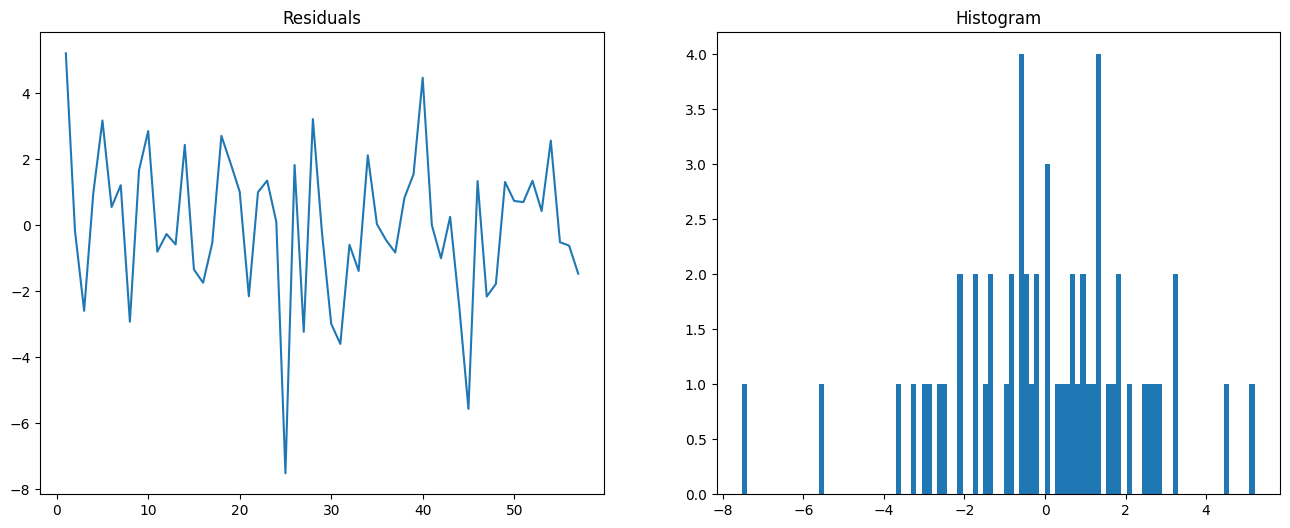

In [11]:
# plot residuals
fig, axs = plt.subplots(1, 2,figsize=(16,6))
axs[0].plot(arma_fitted.resid)
axs[0].set_title("Residuals")
axs[1].hist(arma_fitted.resid,bins=100)
axs[1].set_title("Histogram")
# test for whiteness of residuals 
print("Ljung-Box and Box-Pierce for residual autocorrelation")
res_lb = sm.stats.diagnostic.acorr_ljungbox(arma_fitted.resid, lags=10, boxpierce=True,model_df=0+0)
print(res_lb)
# test for heteroscedasticity
res_het = sm.tsa.stattools.breakvar_heteroskedasticity_test(arma_fitted.resid, subset_length=1/3, alternative="two-sided")
print("Heteroscedasticity test results:")
print(f"P-val: {res_het[1]}")

Both Ljung-Box and Box-Pierce test suggest that there is `no` significant `autocorrelation` in the `residuals` up to lag $10$. With heteroscedasticity test we fail to reject the null hypothesis, meaning there is `no` evidence of `heteroscedasticity` in your `residuals`. The `residual` `variance` appears to be `constant`, which is another good sign for the model.

## Question 3: FORECASTS

- Use the model from point 2 and perform one-step-ahead forecasts, with expanding window, for your series for the remaining 20% of the sample (you can refer to the code from “Ex_multi_TS_real_data.ipynb”).
- Plot the forecasts and the true values. 
- Also, report the RMSE of the forecasts. You will later compare this RMSE to the RMSE obtained in a VAR and NN model. 
- For example, if you have 100 observations, the 1st one-step-ahead forecast: Estimate the model on $T = 1\dots80$ and forecast the value for $T=81$. The 2nd one-step-ahead forecast: Estimate the model on $T = 1\dots81$ and forecast $T=82$, and so on.

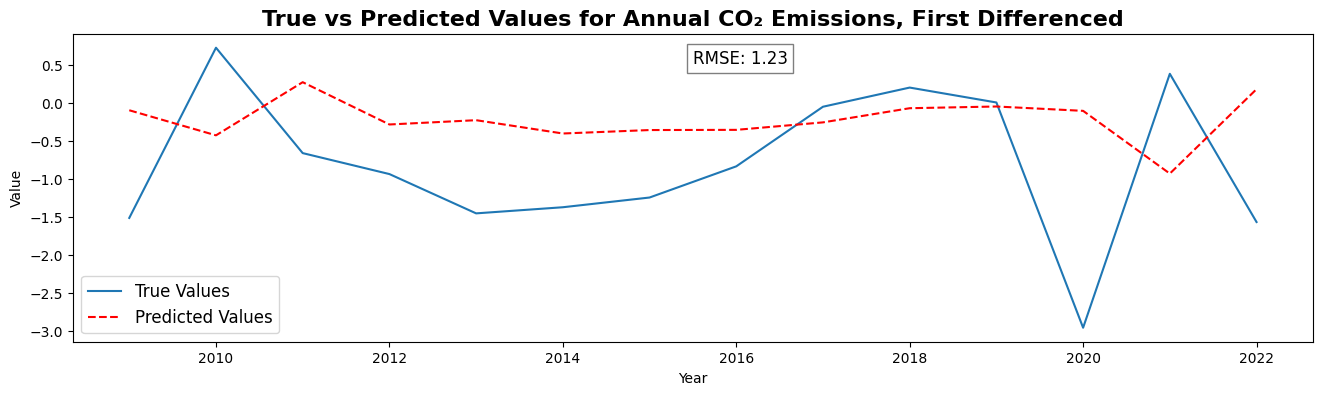

In [19]:
# perform rolling one-step-ahead forecast 
forecasts = []
# loop for 1-step-ahead forecasts on the last 20% of the data
for i in range(train_subset_idx, len(data_smooth_4)):
    # get (0, ..., i) data
    train_data_i = data_smooth_4[stationary_feature][:i]
    # declare and fit the ARIMA(0,0,1) model
    arma_i = sm.tsa.arima.ARIMA(train_data_i, order=(0, 0, 1), trend="c", validate_specification=True)
    arma_fitted_i = arma_i.fit()
    # perform and store forecast
    forecast_i = arma_fitted_i.forecast(steps=1)
    forecasts.append(forecast_i.values[0])

# true values are the last 20% of the data, starting from `train_subset_idx`
true_values = data_smooth_4[stationary_feature][train_subset_idx:].values
# compute RMSE
rmse = root_mean_squared_error(true_values[1:], forecasts[1:])
# plot the results
plt.figure(figsize=(16, 4))
plt.plot(data_smooth_4["year"][train_subset_idx+1:], true_values[1:], label="True Values")
plt.plot(data_smooth_4["year"][train_subset_idx+1:], forecasts[1:], label="Predicted Values", color="red", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Value")
plt.title(f"True vs Predicted Values for {feature_map[stationary_feature]}", fontsize=16, fontweight="bold")
# add RMSE text to the plot
plt.text(0.5, 0.95, f"RMSE: {rmse:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))
plt.legend(fontsize=12)
plt.show()

For further reference, with `ARMA(0,1)` model we obtain  `RMSE=1.23`.

## Question 4: STATIONARITY & ARIMA

- Explain what is the consequence of estimating an ARIMA model on a non-stationary data. 

The stationarity, atleast weak stationarity, for timeseries $y$ is defined as:
- $\mathbb{E}[y_t] = \mathbb{E}[y_{t+k}], \forall t, k$
- $Var(y_t) = Var(y_{t+k}), \forall t, k$
- $Cov(y_t, y_{t-m}) = Cov(y_{t+k}, y_{t+k-m}), \forall t, k$

These assumptions imply that $y_t$ fluctuates around a fixed mean and variance over time, without trends of periodic changes.

First of all, if we estimate *ARMA* model on a non-stationarity series, then the usual statistical tests are not valid, since they assume the stationary of data.

Second, we will not mathematically prove or show why *ARMA* model is not suitable for non-stationary data. Instead, let us look at an example of how *ARMA* model would treat **non-stationary** data. Take data $y_t$ with:

$$y_t=t$$

Clearly, the data is non-stationary, it is constantly increasing. Let us take *AR(1)* model. Then $y_t$ would be modeled as:

$$y_t=\phi y_{t-1} + \epsilon_t$$

- $\phi$: parameter of the AR model.
- $\epsilon_t$: white noise with $\mathbb{E}[\epsilon_t] = 0$.

Then by substituting $y_t=t$ we get:

$$
t=\phi(t-1)+\epsilon_t\\
t(1-\phi) = \epsilon_t - \phi \\
1-\phi=\frac{\epsilon_t-\phi}{t}
$$

As $t$ grows and $\epsilon_t$ is bounded white noise, $\phi \approx 1$, because $\frac{\epsilon_t+\phi}{t}\to0$ (if $\phi > 1$, the modeled series would become explosive). This indicates that *AR(1)* model would interpret the non-stationary trend $y_t=t$ as a random walk process, i.e.:

$$y_t=y_{t-1}+\epsilon_t=\sum^t_{k=1}\epsilon_k$$

We see that the effect of shocks does not decay, meaning the model will not be able to model the series. Now let us look at *ARMA* model, e.g. add *MA(1)* term to *AR(1)*:

$$
y_t=\phi y_{t-1}+\theta\epsilon_{t-1} + \epsilon_t\\
t=\phi (t-1)+\theta\epsilon_{t-1} + \epsilon_t\\
1-\phi=\frac{\epsilon_t+\theta\epsilon_{t-1}-\phi}{t}
$$

Here we arrive to the same conclusions as with *AR(1)* model, but instead of having a random walk $y_t=\sum^t_{k=1}\epsilon_k$, we would add constants $\theta_t$ to each $\epsilon_t$ term, again poorly modeling the series. In other words, adding a moving average term still does not resolve the issue of misinterpretation, as the model would inadequately capture the deterministic trend, interpreting it as a sequence of shocks with persistent effects.

In conclusion, *ARMA* model estimated on non-stationary data will produce predictions that are not reliable over long horizons. Because the model sees non-stationary trends as permanent shocks, it will not correctly predict any reversion to a mean, resulting in misleading forecasts.